# Tutorial #6
# Image Captioning (图像描述)

This course is adapted from [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) 

## 介绍

从机器翻译说起：机器翻译可以一个文本从一种语言翻译成另一种语言。它的工作原理是利用了两个循环神经网络（RNN），第一个称之为编码器，第二个称之为解码器。第一个RNN将源文本编译成一个数字的向量，第二个RNN将这个向量解码成目标文本。编码器和解码器的中间向量类似于对源文本的汇总，它有时候被称为“思维向量”（thought-vector）或“汇总向量”（summary-vector）。用汇总向量（summary-vector）的原因是为了在翻译之前理解整个源文本。这也允许原文本和目标文本有不同的长度。

神经网络不能直接作用到文本上，所以我们首先要用分词器将每一个词转换到整形代号（integer-token）。但是神经网络也不能直接作用在整数上，所以我们要用Embedding层将整形代号（integer-token）转换成浮点形的向量。

举个例子，丹麦语 "der var engang"，是每一个童话故事开始的语句，字面的翻译是"there was once"，但是它通常被翻译成英语"once upon a time"。我们首先将全部的数据集转换成整形代号，所以 "der var engang" 变成了 [12, 54, 1097]。每一个整形代号（integer-tokens）被映射到一个例如有128个元素的嵌入向量（embedding-vector），所以整形代号12可以变成例如[0.12, -0.56, ..., 1.19]，整形代号54可以变成例如 [0.39, 0.09, ..., -0.12].，这些嵌入向量随后可以输入到有3个GRU层的循环神经网络。

从机器翻译到图像描述：在这个教程中将用图像识别模型来代替机器翻译中的编码器，类似迁移学习（Transfer Learning）和微调（Fine-Tuning）。图像模型识别图像中包含的内容并且输出一个数字向量-“思维向量”或者“汇总向量”，然后把它输入到循环神经网络，把向量解码成文本。

## 流程图

我们将使用经过预训练的VGG16模型来对图像进行分类。但是，我们不是使用最后一个分类层,而是将重定向其前一层的输出。这为我们提供了一个包含4096个元素的向量，它汇总了图像内容。我们将使用此向量作为门控循环单元（GRU）的初始状态。然而，GRU的内部状态大小仅为512，因此需要一个中间的全连接（密集）层来将一个具有4096个元素的向量映射到仅一个具有512个元素的向量。

然后，解码器将该初始状态与起始标记“ssss”一起使用以开始产生输出词。 在第一次迭代中，它将有希望输出“big”这个词。 然后我们将这个词输入解码器，希望得到“brown”这个词，依此类推。最后，生成了文本“big brown bear sitting eeee”，其中“eeee”标志着文本的结尾。

该算法的流程图大致是：

![Flowchart](images/06_image_captioning_flowchart.png)

## 导入

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from cache import cache

/home/bai/anaconda2/envs/tfgpu/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


我们需要导入Keras中的一些模块。

In [2]:
# from tf.keras.models import Model  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

开发环境以及一些包的版本：

In [3]:
tf.__version__

'1.9.0'

In [4]:
tf.keras.__version__

'2.1.6-tf'

## 加载数据

我们将使用COCO数据集，它包含许多带有描述文本的图片

http://cocodataset.org

In [5]:
import coco

如果你想将数据文件保存在不同地方，你可以改变数据地址。

In [6]:
coco.set_data_dir("data/coco/")

如果你之前没有准备好数据，它会自动下载和解压。

**注意！这个数据集非常大！训练集有19GB，验证集有816MB！**

下载地址：
http://images.cocodataset.org/zips/train2017.zip

http://images.cocodataset.org/zips/val2017.zip

http://images.cocodataset.org/annotations/annotations_trainval2017.zip

下载后放置目录： data/coco/

In [7]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


获得训练集中图像的文件名和图片描述文本。

In [8]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


训练集图像的数目。

In [9]:
num_images_train = len(filenames_train)
num_images_train

118287

获得验证集中图像的文件名和图片描述文本。

In [10]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


### 加载和显示图像的辅助函数

这是用于图像加载和改变大小的辅助函数。


In [11]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

这是用于显示数据集中图像和图像描述文本的辅助函数。


In [12]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### 举个例子

显示训练集中一个示例图片和它的描述文本。

A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


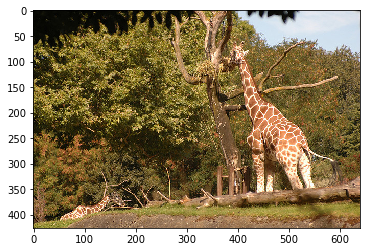

In [13]:
show_image(idx=1, train=True)

## 预训练图像模型 (VGG16)

利用Keras API创建VGG16的一个实例。如果你之前没有这些必须的文件，它们会被自动下载。

VGG16模型经过ImageNet数据集预训练，用于对图像进行分类。VGG16模型包含了卷积部分和全连接部分，用于图像的分类。

如果 `include_top=True`那么整个VGG16模型会被下载，大约528 MB。如果 `include_top=False`那么只有VGG16模型的卷积部分被下载，只有57 MB.

我们将用到预训练模型当中的一些全连接层，所以我们需要下载整个模型，但是如果你的网络接连很慢，你可以尝试修改下面的代码，使用较小的预训练模型，而不需要分类层。

In [14]:
image_model = VGG16(include_top=True, weights='imagenet')

打印VGG16模型所有层的列表。

In [15]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

我们将使用在最后分类层之前的层`fc2`的输出。这是一个全连接层。

In [16]:
transfer_layer = image_model.get_layer('fc2')

我们称它为“迁移层”（transfer-layer），因为我们将它的输出迁移到另一个模型，用于生成图像的描述文本。

为此，我们首先需要创建一个模型，它和原始的VGG16有相同的输入。但是输出是传输层`fc2` 的输出。


In [17]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

模型希望输入的图像大小：

In [18]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

对于每个输入图像，新模型将输出具有长度为4096的一个迁移值向量：

In [19]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### 处理所有图像

现在，我们使用预训练的图像模型来处理数据集中的所有图像，并在cache-file中保存迁移值，它可以被加载的更快。

我们有效地创建了一个新的迁移值数据集。这是因为在VGG16模型中处理图像需要很长时间。我们不会改变VGG16模型的所有参数，因此每次处理图像时，它都会给出完全相同的结果。我们需要迁移值来训练许多epoches的图像描述模型，因此通过计算一次迁移并将它们保存在缓存文件中来节省大量时间。

这是用于打印进度的辅助函数。

In [20]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

这是为了用VGG16模型处理给定文件并返回它们的迁移值的辅助函数。

In [21]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

处理所有训练集图片的辅助函数。这样就可以在cache-file中保存迁移值，以便快速重载。

In [22]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

处理验证集中的所有图片的辅助函数。

In [23]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

处理训练集中所有图像并将迁移值保存到cache文件中。

In [24]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 275 ms, sys: 900 ms, total: 1.18 s
Wall time: 6.51 s


处理验证集中所有图像并将迁移值保存到cache文件中。

In [25]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 17.8 ms, sys: 26.6 ms, total: 44.4 ms
Wall time: 367 ms


## 分词器(Tokenizer)

神经网络不能直接在文本数据上工作。使用两步处理过程将文本转换为可用于神经网络的数字。

第一步是将文本单词转换为所谓的整数代号(integer-tokens)。
第二步是使用嵌入层将整数代号转换为浮点数的向量。 

在开始处理文本之前，首先使用很可能不存在于数据中的唯一单词来标记每个文本序列的开头和结尾。

In [26]:
mark_start = 'ssss '
mark_end = ' eeee'

这个辅助函数将所有文本字符串分装到上面的标记中。由于图片描述文本是一个列表的列表，所以我们需要嵌套一个for循环去处理它。这项工作可以由Python里所谓的 list-comprehension完成。

In [27]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

现在处理训练集中所有的图片描述文本并显示一个例子。

In [28]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

这是没有起始和结束标记的图片描述文本的样子。

In [29]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

这个辅助函数将图片描述文本由一个列表的列表转换成一个展平的列表。

In [30]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

现在用这个函数去转换训练集中被标记过的描述文本。

In [31]:
captions_train_flat = flatten(captions_train_marked)

设置词汇表中的最大单词数目。这表明我们将只用（例如）10000个在训练数据描述文本中出现频率最高的词。


In [32]:
num_words = 10000

我们需要的功能比Keras中分词器类能提供的功能更多，所以将它们封装起来。

In [33]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

现在用训练数据的描述文本创建分词器。注意我们用了描述文本被展平的列表去创建分词器，因为它不能取列表的列表。


In [34]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 10.1 s, sys: 5.65 ms, total: 10.1 s
Wall time: 10.1 s


获取起始标记 （"ssss"）的整形代号。我们将在之后用到。


In [35]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

获取起始结束 （ "eeee"）的整形代号。


In [36]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

将所有的描述文本从数据集转换到整形代号的序列。我们获得一个列表的列表的结果。


In [37]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 8.49 s, sys: 35.2 ms, total: 8.53 s
Wall time: 8.52 s


训练集中第一个图片描述文本整形代号案例：

In [38]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

下面是对应的文本描述：

In [39]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## 数据生成器

训练集中的每一幅图像具有至少5个描述图像内容的题注(captions)。我们将使用批次的图像迁移值和题注的整数代号序列来训练神经网络。如果要为训练集设置匹配的numpy数组，我们要么为每幅图像使用一个题注而忽略其余的有价值的数据，要么必须为每个题注重复图像迁移值，这会浪费大量的内存。

一个更好的解决方案是为Keras创建一个自定义数据生成器，它将创建一个批次的具有随机选择的迁移值和代号序列的数据。

该辅助函数返回具有训练集中给定索引的图像的一个随机的代号序列(token-sequences)的列表。

In [40]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

这个生成器函数创建随机的训练数据，用于训练神经网络。

In [41]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

在训练时设定批的大小。这个值设置非常高，所以可以最大限度地使用GPU。但这也需要GPU上的大量内存。如果内存溢出，你不得不降低这个数字。


In [42]:
batch_size = 1024

创建一个数据生成器的实例。


In [43]:
generator = batch_generator(batch_size=batch_size)

通过创建一个批的数据来测试数据生成器。


In [44]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

在这个批当中第一个图像的迁移值。

In [45]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.181, ..., 0.   , 0.   , 0.631], dtype=float16)

在这个批次当中第一个图像的代号序列。它将被输入到神经网络的解码部分。

In [46]:
batch_x['decoder_input'][0]

array([   2,    1, 3425,  801,  611,    4,    1,  785,    8,    1, 1004,
          3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

这是解码器期望输出的代号序列。注意，这与上面的序列是相同的，除了一个时间步长的偏移。


In [47]:
batch_y['decoder_output'][0]

array([   1, 3425,  801,  611,    4,    1,  785,    8,    1, 1004,    3,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

### 每个epoch的步数

一个epoch是对训练集的完整处理。我们希望单个epoch中处理每一个图像和本文对。然而，每个批是由数据生成器随机产生的，一张图在可能在一个epoch多个批中出现，也有些图可能在一个epoch中在任何批中都没有处理过。

然而，我们仍然使用“epoch”的概念来衡量我们所处理的训练数据的进过了多少次的迭代。但是数据生成器会不停的产生数据，所以我们需要手动计算每个epoch需要的批的大致数量。

下面是训练集中每张图片的文本数量。

In [48]:
num_captions_train = [len(captions) for captions in captions_train]

这是训练集中所有文本的数量。

In [49]:
total_num_captions_train = np.sum(num_captions_train)

如果我们想要每个epoch处理每一文本和图像对，这是每个epoch大致所需的批次数量。

In [50]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

577

## 创建循环神经网络

现在创建循环神经网络(RNN)，它被训练去完成将图像识别模型的迁移值的向量映射到可以转换成文本的整形代号序列。我们称这个神经网络为“解码器”。

注意我们使用了Keras中函数式模型（ functional model）来搭建这个神经网络，因为它可以让神经网络的连接更加灵活。比如你想要进行实验将图像模型直接连接到解码器（见练习）。这意味着我们将网络创建划分成两个部分：（1）创建所有尚未连接的层，（2）一个连接所有这些层的函数。

解码器包含3个GRU层，它们内部状态大小是：

In [51]:
state_size = 512

embedding层将整形代号转换到实数向量的长度：

In [52]:
embedding_size = 128

迁移值到解码器的入口：

In [53]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

我们想要用迁移值去初始化GRU单元的内部状态。这就告诉了GRU单元关于图像的内容。迁移值向量的长度是4096，但是GRU内部状态的大小只有512，所以我们用一个全连接层将向量由4096个元素映射到512个元素。

注意我们使用了`tanh`激活函数去限制映射的输出在-1到1之间，否则可能不能正常工作。

In [54]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

这里将代号序列输入到解码器。使用`None`是因为代号序列可以有不同的长度

In [55]:
decoder_input = Input(shape=(None, ), name='decoder_input')

这是embedding层，将整形代号序列传转换成向量序列。

In [56]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

创建有3个GRU层的解码器。注意它们都返回序列，因为我们最后想要输出一个整形代号的序列，它可以被转换成文本序列。

In [57]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

GRU层最后输出张量的形状是`[batch_size, sequence_length, state_size]`，每一个"词"被编码成长度为`state_size`的向量。我们需要将这些转换到可以用我们的词汇表解释的整形代号序列，

一种方法是将GRU的输出转换成独热编码的数组。它能起效，但是相当浪费，因为词汇表有10000个词，需要有10000个元素的向量，所以可以选择最高元素的索引作为整形代号（integer-token）。

注意激活函数被设置为`linear`来代替`softmax`，就像通常使用独热编码的输出一样，因为Keras中有似乎有一个bug，所以我们需要自己定制一个损失函数，下面会详细介绍。

In [58]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### 连接和创建训练模型

这个解码器用Keras的函数式API搭建，它允许更灵活地连接网络层，例如有多个输入。这是很有用的，例如你想要将图像模型直接与解码器相连，来代替预先计算的迁移值。

这个函数完成编码器的连接。

In [59]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

连接和创建用于训练的模型。它以迁移值和整形代号序列作为输入，以可以转换为整形代号的独热数组序列作为输出。

In [60]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### 损失函数

解码器的输出是独热编码数组的序列。为了训练解码器，需要提供我们希望看到的解码器输出的独热编码数组，然后用一个损失函数（像交叉熵）去训练解码器产生期望的输出。

然而，我们的数据集包含整形代号，而不是独热编码数组。每一个独热编码数组有10000个元素，所以将全部的数据集转换到独热编码数组是相当浪费的。我们可以在上面的`batch_generator()`中进行从整数到一个独热数组的转换。

一个更好的方法是使用所谓的稀疏交叉熵（sparse cross-entropy ）损失函数，它在内部将整数转换成独热数组。不幸的是，当和循环神经网络一起使用的时候，Keras似乎存在一个bug，所以下面的方式不起效：


In [61]:
# decoder_model.compile(optimizer=optimizer,
#                       loss='sparse_categorical_crossentropy')

解码器输出3阶形状 `[batch_size, sequence_length, num_words]`是张量，它包含了一批长度为`num_words`的独热数组的序列。我们将它与包含了整形序列的2阶`[batch_size, sequence_length]`张量作比较。

比较由Tensorflow中的稀疏交叉熵（sparse-cross-entropy）直接完成。下面还有一些需要注意的事项。

首先，为了提高数值的稳定性，损失函数在内部计算softamax，这也是为什么我们在解码器网络最后的全连接层中用了线性激活函数。

第二，TensoFlow的损失函数输出的是形状为`[batch_size, sequence_length]`的二阶张量。但是它最终要被转换为一个单独标量值，它的梯度可以被TensorFlow推导并可以用梯度下降来优化。Keras支持在批处理中对损失值进行加权，但描述的不清楚，所以为了确保我们计算的损失函数经过了整个批处理和整个序列，我们手工计算损失平均值。


In [62]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### 编译训练模型

我们在之前的教程中用了Adam优化器，但是在一些试验中发现它与循环神经网络有冲突。RMSprop在这似乎表现的更好一些。

In [63]:
optimizer = RMSprop(lr=1e-3)

Keras在这里似乎又有一个bug，它不能自动的推断正确的编码器输出的形状。因此我们需要手动创建一个占位符变量来作为解码器的输出。它的形状被设置成`(None, None)`，意味着这批可以有任意数量的序列，任意数量的整形代号。

In [64]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

我们现在可以用自己定制的损失函数编译模型。

In [65]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### 回调函数
在训练时，我们希望保存checkpoints并将进展记录到TensorBoard中，所以用了Keras中的相应回调。

下面是在训练时保存checkpoints的回调。

In [66]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

下面是在训练时写TensorBoard日志的回调。

In [67]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [68]:
callbacks = [callback_checkpoint, callback_tensorboard]

### 加载 Checkpoint

我们可以重新加载最后保存的checkpoint ，所以每当我们想要使用这个模型时，不需要再训练它。

In [69]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (Unable to open file: name = '22_checkpoint.keras', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)


### 训练模型

现在我们将训练这个解码器，那样它可以将图像模型的传输值映射到图像描述文本的整形代号序列。

在GTX 1070 GPU上训练一个epoch花费大约7分钟。你可能需要运行20个epoch或者更多。

注意：如果我们不使用预先计算的迁移值，那么每个epoch将会花费大约40分钟，因为所有的图像都必须由VGG16模型进行处理。


In [70]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

Epoch 1/20


/home/bai/anaconda2/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


576/577 [============================>.] - ETA: 0s - loss: 1.6856
Epoch 00001: saving model to 22_checkpoint.keras
577/577 [==============================] - 251s 435ms/step - loss: 1.6852
Epoch 2/20
576/577 [============================>.] - ETA: 0s - loss: 1.1131
Epoch 00002: saving model to 22_checkpoint.keras
577/577 [==============================] - 262s 454ms/step - loss: 1.1129
Epoch 3/20
576/577 [============================>.] - ETA: 0s - loss: 1.0093
Epoch 00003: saving model to 22_checkpoint.keras
577/577 [==============================] - 266s 461ms/step - loss: 1.0092
Epoch 4/20
576/577 [============================>.] - ETA: 0s - loss: 0.9714
Epoch 00004: saving model to 22_checkpoint.keras
577/577 [==============================] - 261s 453ms/step - loss: 0.9717
Epoch 5/20
576/577 [============================>.] - ETA: 0s - loss: 0.9561
Epoch 00005: saving model to 22_checkpoint.keras
577/577 [==============================] - 251s 436ms/step - loss: 0.9556
Epoch 6/20


## 生成图像描述文本

这个函数用于加载一个图像并用我们训练好的模型生成描述文本。


In [71]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

### 例子

试试这张鹦鹉的照片。

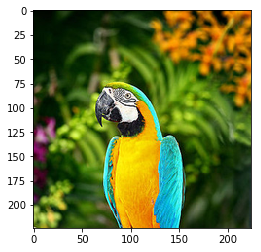

Predicted caption:
 a bird sitting on a branch of a tree eeee



In [73]:
generate_caption("images/parrot_cropped1.jpg")


试试这张任务的照片（Elon Musk）。

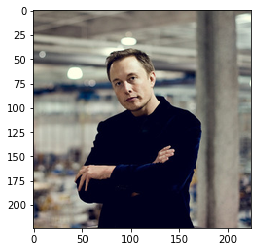

Predicted caption:
 a man in a suit and tie standing next to a wall eeee



In [74]:
generate_caption("images/elon_musk.jpg")

用于从COCO数据集中加载一张图片并打印出它正确的描述和预测的描述的辅助函数。

In [75]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

试着在训练好的模型上用这张训练集中的图片。在某些情况下，生成的描述文本实际上比人工生成的描述要好。


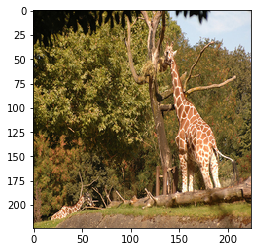

Predicted caption:
 a giraffe standing in a field next to a forest eeee

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [76]:
generate_caption_coco(idx=1, train=True)

下面是训练集中另一张长颈鹿的照片，这张图片在训练模型的时候被使用过，但是这个模型不能生成正确的描述。可能它需要更多的训练，或者其他结构的循环神经网络？


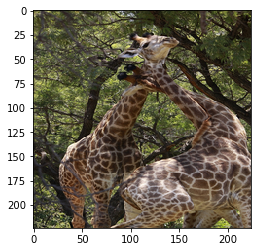

Predicted caption:
 a giraffe standing next to a tree in a forest eeee

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [77]:
generate_caption_coco(idx=10, train=True)

这是验证集中的图片，它没有被用到神经网络的训练。有些时候模型可以对没有见过的图像生成好的描述文本，但也有的时候不能。你能让模型变得更好吗？


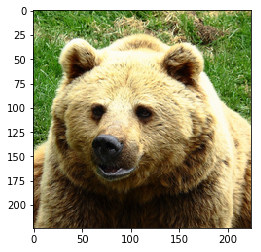

Predicted caption:
 a cat sitting on a couch next to a remote eeee

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [78]:
generate_caption_coco(idx=1, train=False)

## 总结

这份教程展示了如果为一张图片生成描述文本。我们用了预训练图像模型（VGG16）产生图像内容的“思维向量”，然后训练循环神经网络将“思维向量”映射到一个单词序列。

这项工作完成的相当好，尽管在训练和验证集里很容易找到例子说明描述是不正确的

理解这个模型并没有像人类一样理解图片的内容是很重要的。只能说明如果它看到了长颈鹿的图像并且产生了一个正确的描述，这并不意味着模型理解了什么是长颈鹿，它不能理解长颈鹿是一个生活在非洲草原里的一个高大的动物。


模型仅仅是以一个聪明的方法将图像中的像素映射到汇总图像内容的浮点数上，然后将这些数映射到代表单词的整形代号的序列上。所以这个模型本质上就是一个非常高级的函数近似器，而不是像人类一样的智能。


## 练习

下面使一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 训练更多的epochs。生成描述文本的质量提高了吗？
* 用另一个架构循环神经网络，例如改变GRU层的个数，它们内部状态的大小，embedding层的大小等等。你可以提高生成描述文本的质量吗？
* 用VGG16模型的另一个传输层，例如展平最后一个卷积层的输出。
* 尝试在传输值和解码器初始状态映射间增加更多的全连接层。
* 当生成描述时，你能不能把解码器的输出样本看作是概率分布，来代替使用 np.argmax()对下一个整形代号的采样？注意解码器的输出不受softmax的限制，所以你必须先把它变成概率分布。
* 你可以通过做这个采样来生成多个序列吗？你能找到一种方法来选择这些不同序列中最好的吗？
* 直接将图像模型与解码器相连，那么你可以微调图像模型的权重。
* 你能用一些数学公式来衡量生成的描述文本的质量吗？
* 修改解码器，让它也返回GRU单元的状态。然后改变`generate_caption()`，让它在没次迭代只输入和输出一个整形代号。你需要从`decoder_model.predict()`获得GRU状态，并在你下次调用的时候将状态喂入。现在你每次迭代计算量很少，但是任然会产生很多开销，所以在使用GPU时它可能不会快很多？
* 向朋友解释程序是如何工作的。

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.